In [7]:
import wandb
import datetime
import itertools as it

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np

from matplotlib import cm as cm

api = wandb.Api()
#run = api.run(f"marauders/TFC_pre-training/kkq3pnzk")


In [55]:
def plot_results(data1, data2, data3, data4):

    # Define subplot sizes
    # print("shape of 0: ", data1.shape)
    # print("shape of 1: ", data2.shape)
    # print("shape of 2: ", data3.shape)
    # print("shape of 3: ", data4.shape)

    subplot_sizes = [(1, 4), (4, 4), (1, 4), (1, 1)]  # (height, width) for each subplot

    # Create a figure and subplots with specified sizes
    fig, axes = plt.subplots(4, 1, figsize=(12, 12), gridspec_kw={'height_ratios': [size[0] for size in subplot_sizes]})

    # Combine data from all plots to find common vmin and vmax
    all_data = np.concatenate([data1.flatten(), data2.flatten(), data3.flatten(), data4.flatten()])
    vmin = np.min(all_data)
    vmax = np.max(all_data)

    # Just the upper triangle for data2
    mask =  np.tri(data2.shape[0], k=0)
    data2 = np.ma.array(data2, mask=mask) # mask out the lower triangle
    # cmap = cm.get_cmap('jet', 10) # jet doesn't have white color
    # cmap.set_bad('w') # default value is 'k'

    # Plot heat maps with adjusted aspect ratio
    im1 = axes[0].imshow(data1, cmap = 'hot', norm = "linear", interpolation = 'nearest', aspect = "auto", vmin = vmin, vmax = vmax)
    im2 = axes[1].imshow(data2, cmap = 'hot', norm = "linear", interpolation = 'nearest', aspect = "auto", vmin = vmin, vmax = vmax)
    im3 = axes[2].imshow(data3, cmap = 'hot', norm = "linear", interpolation = 'nearest', aspect = "auto", vmin = vmin, vmax = vmax)
    im4 = axes[3].imshow(data4, cmap = 'hot', norm = "linear", interpolation = 'nearest', aspect = 'equal', vmin = vmin, vmax = vmax)

    # Labels for plots, using A, B, C, D for simplicity
    axes[0].set_xticks(np.arange(4))  # Set x ticks
    axes[0].set_xticklabels(["A", "B", "C", "D"], fontsize = 14)  # Set x tick labels
    axes[0].yaxis.set_ticks([])
    axes[0].set_yticklabels([])

    axes[1].set_xticks(np.arange(4))  # Set x ticks
    axes[1].set_xticklabels(["A", "B", "C", "D"], fontsize = 14)  # Set x tick labels
    axes[1].set_yticks(np.arange(4))  # Set x ticks
    axes[1].set_yticklabels(["A", "B", "C", "D"], fontsize = 14)  # Set y tick labels

    axes[2].set_xticks(np.arange(4))  # Set x ticks
    axes[2].set_xticklabels(["ABC", "ABD", "ACD", "BCD"], fontsize = 14)  # Set x tick labels
    axes[2].yaxis.set_ticks([])
    axes[2].set_yticklabels([])

    axes[3].set_xticks(np.arange(1))  # Set x ticks
    axes[3].set_xticklabels(["ABCD"], fontsize = 14)  # Set x tick labels
    axes[3].yaxis.set_ticks([])
    axes[3].set_yticklabels([])
    # axes[0].set_yticks(np.arange(len(data)))  # Set y ticks
    # axes[0].set_yticklabels(np.arange(1, len(data) + 1))  # Set y tick labels
    
    # Set the title for figure
    fig.suptitle("The heatmap of training on different pre_train dataset setups and finetuning on Epilepsy", fontsize = 16 )

    # Add the explanation text for the dataset abbreviation
    plt.text(0.5, 0.02,  'A = SleepEEG; B = FD_A; C = HAR; D = ECG', fontsize = 14, horizontalalignment='center', verticalalignment='center', transform=plt.gcf().transFigure)
    
    # Adjust space between subplots
    plt.subplots_adjust(hspace=0.5, wspace=0.5)

    # Add colorbar
    cb = plt.colorbar(im2, ax = axes, orientation = 'vertical')
    cb.ax.tick_params(labelsize = 14)
    # Adjust layout
    # plt.tight_layout()

    # Show plot
    plt.show()

In [8]:
def get_experiments(datasets, dt = datetime.datetime(2024,4,1)):
    filters = {
        "summary_metrics.pre_train_dataset" : datasets,             # Datasets to collect
        "summary_metrics.mode": "fine_tune_test",                   # During fine_tune_test
        "summary_metrics._timestamp" : {"$gte" : dt.timestamp()} }  # The run was created after
    
    runs = api.runs(path = "marauders/TFC_pre-training", filters = filters) 

    return runs

In [9]:
def get_avg_auc(runs):
    avg_auc = []
    for run in runs:
        curr_auc = run.summary['test/metrics/total_auc']
        avg_auc.append(curr_auc)

    if len(avg_auc): 
        return sum(avg_auc)/len(avg_auc)
    else: return 0

In [17]:
def experiment():
    datasets = ["SleepEEG", "FD_A", "HAR", "ECG"]

    single_dataset_runs = [get_experiments([ds]) for ds in datasets]
    double_dataset_runs = [get_experiments(pair) for pair in it.product(datasets, datasets)]
    triple_dataset_runs = [get_experiments(triplet) for triplet in it.combinations(datasets, 3)]
    all_dataset_runs    = [get_experiments(datasets)]

    single_dataset_auc = np.array( [get_avg_auc(runs) for runs in single_dataset_runs] ).reshape(1,4)
    double_dataset_auc = np.array( [get_avg_auc(runs) for runs in double_dataset_runs] ).reshape(4,4)
    triple_dataset_auc = np.array( [get_avg_auc(runs) for runs in triple_dataset_runs] ).reshape(1,4)
    all_dataset_auc = np.array( [get_avg_auc(runs) for runs in all_dataset_runs] ).reshape(1,1)

    plot_results(single_dataset_auc, double_dataset_auc, triple_dataset_auc, all_dataset_auc)

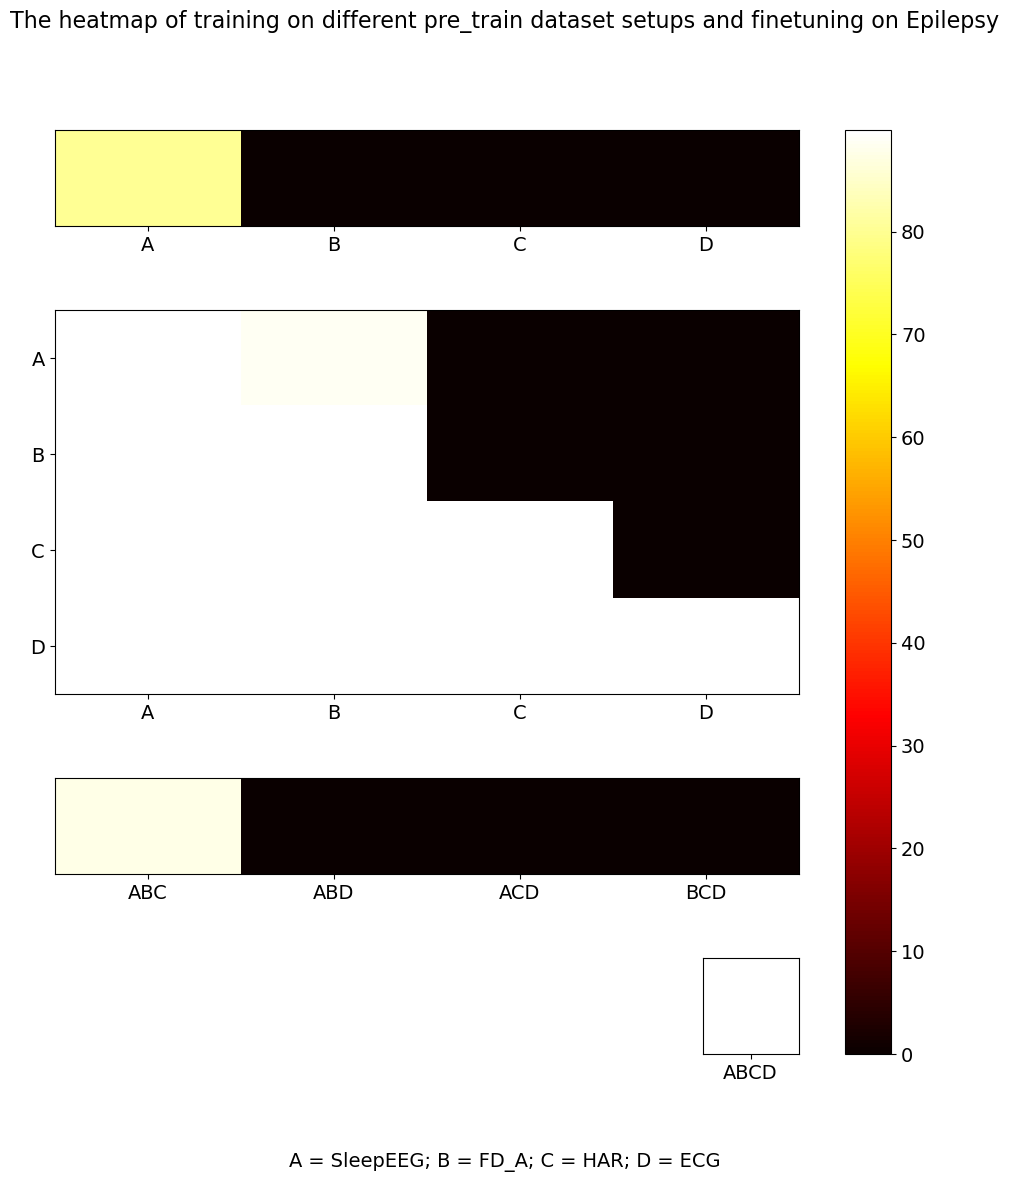

In [56]:
experiment()

In [22]:
datasets = ["SleepEEG", "FD_A", "HAR", "ECG"]
list_of_datasets = []

for pair in it.combinations(datasets, 3):
    print(pair)
    list_of_datasets.append(f"{pair}")

array_of_datasets = np.array( list_of_datasets ).reshape(1,4)
print(array_of_datasets)

('SleepEEG', 'FD_A', 'HAR')
('SleepEEG', 'FD_A', 'ECG')
('SleepEEG', 'HAR', 'ECG')
('FD_A', 'HAR', 'ECG')
[["('SleepEEG', 'FD_A', 'HAR')" "('SleepEEG', 'FD_A', 'ECG')"
  "('SleepEEG', 'HAR', 'ECG')" "('FD_A', 'HAR', 'ECG')"]]


In [ ]:
    # Generate random data
    # data1 = np.random.rand(1, 4)
    # data2 = np.random.rand(4, 4)
    # data3 = np.random.rand(1, 4)
    # data4 = np.random.rand(1, 1)

/tmp/ipykernel_4001273/1455269226.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = CM.get_cmap('jet', 10) # jet doesn't have white color


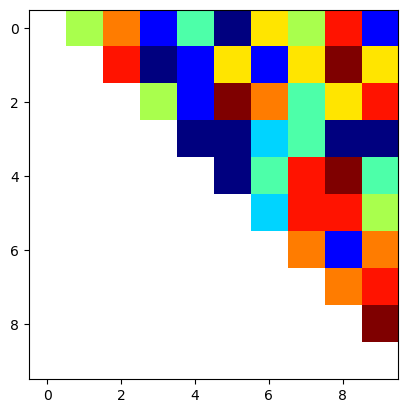

In [12]:
import numpy as NP
from matplotlib import pyplot as plt
from matplotlib import cm as CM

A = NP.random.randint(10, 100, 100).reshape(10, 10)
mask =  NP.tri(A.shape[0], k=0)
A = NP.ma.array(A, mask=mask) # mask out the lower triangle
fig = plt.figure()
ax1 = fig.add_subplot(111)
cmap = CM.get_cmap('jet', 10) # jet doesn't have white color
cmap.set_bad('w') # default value is 'k'
ax1.imshow(A, interpolation="nearest", cmap=cmap)
ax1.grid(False)
plt.show()


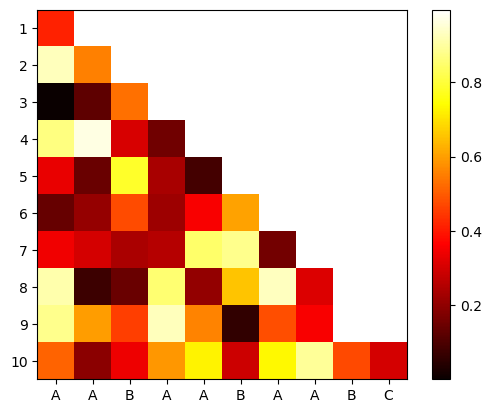

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Generate sample data
data = np.random.rand(10, 10)  # Example 10x10 heatmap data

# Create a mask for the lower triangle
mask = np.tril(np.ones_like(data), k=0)

# Apply the mask to the data
masked_data = np.ma.masked_where(mask == 0, data)

# Plot the heatmap
plt.imshow(masked_data, cmap='hot', interpolation='nearest')

# Add x and y labels
plt.xticks(np.arange(len(data)), labels= ["A", "A", "B", "A", "A", "B", "A", "A", "B", "C"])
plt.yticks(np.arange(len(data)), labels=np.arange(1, len(data) + 1))

plt.colorbar()
plt.show()
